In [1]:
import json
import pickle

from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
from scipy.linalg import norm

from sklearn.decomposition import PCA, TruncatedSVD

from matplotlib import pyplot as plt
from IPython.display import HTML, display
import pandas as pd
import numpy as np


In [2]:
with open("stored_variables/user_subreddit_tf.pickle", "rb") as f:
    subreddit_tf = pickle.load(f)

In [3]:
with open("stored_variables/user_subreddit_df_mat.pickle", "rb") as f:
    subreddit_df_mat = pickle.load(f)

In [4]:
with open("stored_variables/user_subreddit_tf_auths.pickle", "rb") as f:
    author_names = pickle.load(f)

In [5]:
with open("stored_variables/user_subreddit_tf_subreddit_names.pickle", "rb") as f:
    subreddit_reverse_dict = pickle.load(f)

## Cosine similarity

In [6]:
subreddit_tf_c = coo_matrix(subreddit_tf)

In [7]:
subreddit_df_c = coo_matrix(subreddit_df_mat)

In [8]:
subreddit_idf = np.log(subreddit_df_c.sum() / (subreddit_df_c.sum(axis=0) + 1))

In [9]:
subreddit_tfidf = csr_matrix(subreddit_tf_c.multiply(subreddit_idf))

In [13]:
subreddit_tfidf_norms = np.zeros(subreddit_tfidf.shape[0])

In [14]:
for i in range(20):
    subreddit_tfidf_norms[i*1000 : (i+1) * 1000] = norm(subreddit_tfidf[i*1000 : (i+1) * 1000].toarray(), axis=1)

In [15]:
subreddit_tfidf_normalized = csr_matrix(subreddit_tfidf / subreddit_tfidf_norms[:, np.newaxis])

In [14]:
subreddit_cosine_sims = np.zeros((subreddit_tfidf.shape[0], subreddit_tfidf.shape[0]))

In [15]:
for i in range(20):
    chunk1 = subreddit_tfidf_normalized[i*1000 : (i+1)*1000, :]
    for j in range(20):
        chunk2 = subreddit_tfidf_normalized[j*1000 : (j+1)*1000, :]
        subreddit_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(csc_matrix(chunk2.T)).toarray()


In [16]:
for i in range(subreddit_tfidf.shape[0]):
    subreddit_cosine_sims[i,i] = 0

In [7]:
# with open("stored_variables/user_subreddit_tfidf_cossims.pickle", "wb") as f:
#     pickle.dump(subreddit_cosine_sims, f)
with open("stored_variables/user_subreddit_tfidf_cossims.pickle", "rb") as f:
    subreddit_cosine_sims = pickle.load(f)

In [13]:
most_similar_user = np.zeros(subreddit_tfidf.shape[0], dtype = np.int32)

In [14]:
for i in range(subreddit_tfidf.shape[0]):
    most_similar_user[i] = np.argsort(subreddit_cosine_sims[i])[-1]

In [15]:
most_similar_user[:10]

array([17655,    16,  6234,   202, 16449, 16449,   946,    20, 12246,
         143], dtype=int32)

In [16]:
[subreddit_cosine_sims[i, most_similar_user[i]] for i in range(10)]

[0.8121707495243793,
 0.6337431236865456,
 0.7519535958858542,
 0.866248873336835,
 0.8842001371009686,
 0.640120700372724,
 0.6579174327963478,
 0.9480065628775193,
 0.9820935090201509,
 0.7914165081149797]

## Check similarities by subreddits authors commented in

In [10]:
author_reverse_dict = {author_names[i]:i for i in range(len(author_names))}

In [11]:
num_sanders = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['sandersforpresident']]) for k in author_names}
num_trump = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['the_donald']]) for k in author_names}
num_clinton = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['hillaryclinton']]) for k in author_names}
num_politics = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['politics']]) for k in author_names}


In [12]:
comment_threshold = 10

In [13]:
sanders_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_sanders[author_names[i]] >= comment_threshold]
trump_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_trump[author_names[i]] >= comment_threshold]
clinton_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_clinton[author_names[i]] >= comment_threshold]

In [14]:
none_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_sanders[author_names[i]] == 0 and 
                     num_trump[author_names[i]] == 0 and
                     num_clinton[author_names[i]] == 0]

In [25]:
print(len(sanders_user_indices))
print(len(trump_user_indices))
print(len(clinton_user_indices))
print(len(none_user_indices))

1557
919
137
12958


In [28]:
print(len(set(sanders_user_indices).intersection(trump_user_indices)))
print(len(set(sanders_user_indices).intersection(clinton_user_indices)))
print(len(set(trump_user_indices).intersection(clinton_user_indices)))

206
73
18


In [29]:
np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.138818073116637

In [30]:
np.sum(subreddit_cosine_sims[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.14352057932099493

In [31]:
np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.12949415279378929

In [32]:
np.sum(subreddit_cosine_sims[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.0982426762905685

In [33]:
np.sum(subreddit_cosine_sims) / (subreddit_cosine_sims.shape[0] * (subreddit_cosine_sims.shape[1] - 1))

0.09393301351386252

In [34]:
print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.08808657193636073
0.10329472681020092
0.06596397218776581

0.0914953263809247
0.07740057658285684
0.06820820982044046


In [36]:
len(none_user_indices)

12958

In [34]:
print(len([i for i in most_similar_user[sanders_user_indices] if i in set(sanders_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[sanders_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user[sanders_user_indices] if i in set(trump_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[sanders_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user[sanders_user_indices] if i in set(clinton_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[sanders_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user[sanders_user_indices] if i in set(none_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[sanders_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(sanders_user_indices)))
print()
print(len([i for i in most_similar_user[trump_user_indices] if i in set(sanders_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[trump_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user[trump_user_indices] if i in set(trump_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[trump_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user[trump_user_indices] if i in set(clinton_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[trump_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user[trump_user_indices] if i in set(none_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[trump_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(trump_user_indices)))
print()
print(len([i for i in most_similar_user[clinton_user_indices] if i in set(sanders_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[clinton_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user[clinton_user_indices] if i in set(trump_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[clinton_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user[clinton_user_indices] if i in set(clinton_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[clinton_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user[clinton_user_indices] if i in set(none_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[clinton_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(clinton_user_indices)))
print()
print(len([i for i in most_similar_user[none_user_indices] if i in set(sanders_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[none_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(none_user_indices)))
print(len([i for i in most_similar_user[none_user_indices] if i in set(trump_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[none_user_indices] if i in set(trump_user_indices)])/(len(none_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user[none_user_indices] if i in set(clinton_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[none_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(none_user_indices)))
print(len([i for i in most_similar_user[none_user_indices] if i in set(none_user_indices)]))
print(subreddit_cosine_sims.shape[0] * len([i for i in most_similar_user[none_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(none_user_indices)))


388
3.200991317311052
75
1.0483037397187611
22
2.0627352807429595
727
0.7206722811696461

71
0.9923942069337605
273
6.464897147748949
7
1.1119671493133603
386
0.6482817761778616

29
2.719060142797538
2
0.3177048998038172
28
29.836432415152647
58
0.6534305668059526

567
0.5620649015449648
304
0.5105638859017356
38
0.42810968170045166
9343
1.1128596428734185


In [26]:
sanders_sanders_sims = []

for i in range(len(sanders_user_indices)):
    for j in range(i+1, len(sanders_user_indices)):
        sanders_sanders_sims.append(subreddit_cosine_sims[sanders_user_indices[i],sanders_user_indices[j]])

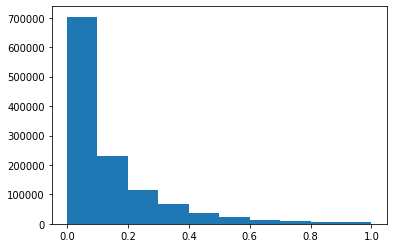

In [27]:
plt.hist(sanders_sanders_sims, range = (0, 1))
plt.show()

In [28]:
trump_trump_sims = []

for i in range(len(trump_user_indices)):
    for j in range(i+1, len(trump_user_indices)):
        trump_trump_sims.append(subreddit_cosine_sims[trump_user_indices[i],trump_user_indices[j]])

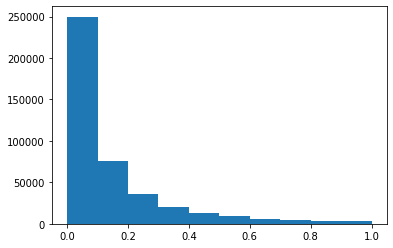

In [29]:
plt.hist(trump_trump_sims, range = (0,1))
plt.show()

In [34]:
clinton_clinton_sims = []

for i in range(len(clinton_user_indices)):
    for j in range(i+1, len(clinton_user_indices)):
        clinton_clinton_sims.append(subreddit_cosine_sims[clinton_user_indices[i],clinton_user_indices[j]])

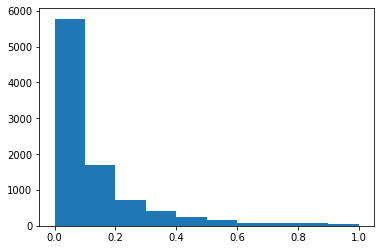

In [35]:
plt.hist(clinton_clinton_sims, range = (0,1))
plt.show()

In [37]:
none_none_sims = []

for i in range(len(none_user_indices)):
    for j in range(i+1, len(none_user_indices)):
        none_none_sims.append(subreddit_cosine_sims[none_user_indices[i],none_user_indices[j]])

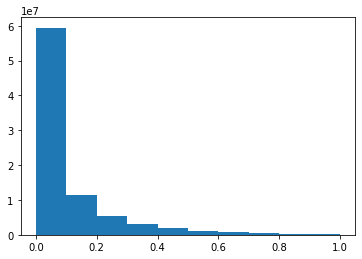

In [38]:
plt.hist(none_none_sims, range = (0,1))
plt.show()

## Use SVD

In [37]:
user_svd = TruncatedSVD(n_components = 100)
user_svd_points = user_svd.fit_transform(subreddit_tfidf)

In [38]:
user_svd_norms = np.zeros(subreddit_tfidf.shape[0])

In [39]:
for i in range(20):
    user_svd_norms[i*1000 : (i+1) * 1000] = norm(user_svd_points[i*1000 : (i+1) * 1000], axis=1)

In [40]:
user_svd_norms[:10]

array([ 1775.24824427,   880.26298633,  5447.13939708, 21340.44191801,
        3417.47318776,  2496.16597088,  1440.834594  ,  9980.56087219,
         797.29651938,  7851.80242155])

In [41]:
user_svd_normalized = user_svd_points / user_svd_norms[:, np.newaxis]

In [42]:
svd_cosine_sims = np.zeros((subreddit_tfidf.shape[0], subreddit_tfidf.shape[0]))

In [43]:
for i in range(20):
    chunk1 = csr_matrix(user_svd_normalized[i*1000 : (i+1)*1000, :])
    for j in range(i,20):
        chunk2 = csc_matrix(user_svd_normalized[j*1000 : (j+1)*1000, :].T)
        svd_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(chunk2).toarray()


In [44]:
svd_cosine_sims[:10,:10]

array([[1.        , 0.59783156, 0.40808062, 0.62739787, 0.78348443,
        0.58775661, 0.79592686, 0.83958192, 0.11066431, 0.77334763],
       [0.59783156, 1.        , 0.3494453 , 0.70089828, 0.6741954 ,
        0.50892622, 0.69959947, 0.70931297, 0.09492274, 0.68977752],
       [0.40808062, 0.3494453 , 1.        , 0.72766971, 0.20737886,
        0.34067713, 0.3402866 , 0.35578086, 0.04695287, 0.35552503],
       [0.62739787, 0.70089828, 0.72766971, 1.        , 0.55633985,
        0.47124046, 0.67937756, 0.70789241, 0.06972697, 0.67992669],
       [0.78348443, 0.6741954 , 0.20737886, 0.55633985, 1.        ,
        0.68528983, 0.90414785, 0.93492961, 0.13880342, 0.79163326],
       [0.58775661, 0.50892622, 0.34067713, 0.47124046, 0.68528983,
        1.        , 0.63408559, 0.61578314, 0.15669713, 0.66496741],
       [0.79592686, 0.69959947, 0.3402866 , 0.67937756, 0.90414785,
        0.63408559, 1.        , 0.93237353, 0.10502594, 0.85535597],
       [0.83958192, 0.70931297, 0.3557808

In [45]:
for i in range(subreddit_tfidf.shape[0]):
    svd_cosine_sims[i,i] = 0

In [46]:
for i in range(20):
    for j in range(i):
        svd_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = \
svd_cosine_sims[j*1000 : (j+1)*1000, i*1000 : (i+1)*1000].T

In [47]:
svd_cosine_sims[3872,10415]

0.508960569591113

In [48]:
svd_cosine_sims[10415,3872]

0.508960569591113

In [10]:
# with open("stored_variables/user_subreddit_tfidf_cossims_svd.pickle", "wb") as f:
#     pickle.dump(svd_cosine_sims, f)
    
with open("stored_variables/user_subreddit_tfidf_cossims_svd.pickle", "rb") as f:
    svd_cosine_sims = pickle.load(f)

In [11]:
most_similar_user_svd = np.zeros(subreddit_tfidf.shape[0], dtype = np.int32)

In [12]:
for i in range(subreddit_tfidf.shape[0]):
    most_similar_user_svd[i] = np.argsort(svd_cosine_sims[i])[-1]

In [13]:
most_similar_user_svd[:10]

array([   26,    16,   828,   946,    55,   387,    64,   942, 12012,
          43], dtype=int32)

In [14]:
[svd_cosine_sims[i, most_similar_user_svd[i]] for i in range(10)]

[0.9050887691107955,
 0.8608446140501907,
 0.9729882375039631,
 0.9844443954397757,
 0.9586222798420735,
 0.7786442459705354,
 0.9594219256049812,
 0.9672330120406901,
 0.9878724312473057,
 0.9254776235273965]

In [21]:
np.sum(svd_cosine_sims[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.2746565831547423

In [22]:
np.sum(svd_cosine_sims[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.2205481866397959

In [23]:
np.sum(svd_cosine_sims[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.2144278529447884

In [24]:
np.sum(svd_cosine_sims[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.2544427543055414

In [25]:
np.sum(svd_cosine_sims) / (svd_cosine_sims.shape[0] * (svd_cosine_sims.shape[1] - 1))

0.2407352022258243

In [26]:
print(np.sum(svd_cosine_sims[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(svd_cosine_sims[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(svd_cosine_sims[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(svd_cosine_sims[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.2071979053595563
0.21401350748864878
0.17404158396285827

0.21328407065037644
0.21526508353747892
0.17024786352852583


In [29]:
print(len([i for i in most_similar_user_svd[sanders_user_indices] if i in set(sanders_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[sanders_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user_svd[sanders_user_indices] if i in set(trump_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[sanders_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user_svd[sanders_user_indices] if i in set(clinton_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[sanders_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user_svd[sanders_user_indices] if i in set(none_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[sanders_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(sanders_user_indices)))
print()
print(len([i for i in most_similar_user_svd[trump_user_indices] if i in set(sanders_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[trump_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_svd[trump_user_indices] if i in set(trump_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[trump_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_svd[trump_user_indices] if i in set(clinton_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[trump_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_svd[trump_user_indices] if i in set(none_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[trump_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(trump_user_indices)))
print()
print(len([i for i in most_similar_user_svd[clinton_user_indices] if i in set(sanders_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[clinton_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user_svd[clinton_user_indices] if i in set(trump_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[clinton_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user_svd[clinton_user_indices] if i in set(clinton_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[clinton_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user_svd[clinton_user_indices] if i in set(none_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[clinton_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(clinton_user_indices)))
print()
print(len([i for i in most_similar_user_svd[none_user_indices] if i in set(sanders_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[none_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(none_user_indices)))
print(len([i for i in most_similar_user_svd[none_user_indices] if i in set(trump_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[none_user_indices] if i in set(trump_user_indices)])/(len(none_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_svd[none_user_indices] if i in set(clinton_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[none_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(none_user_indices)))
print(len([i for i in most_similar_user_svd[none_user_indices] if i in set(none_user_indices)]))
print(svd_cosine_sims.shape[0] * len([i for i in most_similar_user_svd[none_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(none_user_indices)))


534
4.405488050113664
97
1.3558061700362642
30
2.8128208373767634
562
0.5571084209316934

81
1.132168038896262
178
4.215207664100047
8
1.2708195992152689
448
0.7524099371183472

31
2.9065815319559887
8
1.2708195992152689
11
11.72145559166711
64
0.7210268323376028

490
0.4857351001005868
405
0.6801920190467201
46
0.518238035742652
9452
1.1258428068542816


In [55]:
sanders_sanders_sims = []

for i in range(len(sanders_user_indices)):
    for j in range(i+1, len(sanders_user_indices)):
        sanders_sanders_sims.append(svd_cosine_sims[sanders_user_indices[i],sanders_user_indices[j]])

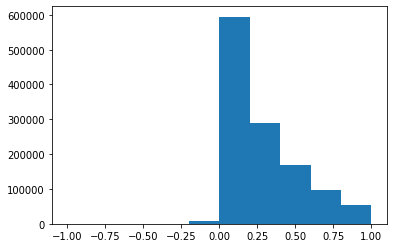

In [56]:
plt.hist(sanders_sanders_sims, range = (-1,1))
plt.show()

In [57]:
trump_trump_sims = []

for i in range(len(trump_user_indices)):
    for j in range(i+1, len(trump_user_indices)):
        trump_trump_sims.append(svd_cosine_sims[trump_user_indices[i],trump_user_indices[j]])

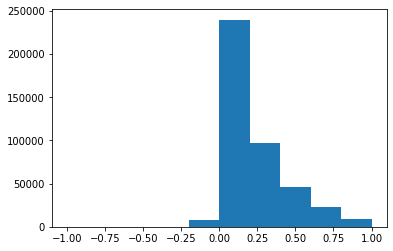

In [58]:
plt.hist(trump_trump_sims, range = (-1,1) )
plt.show()

In [59]:
clinton_clinton_sims = []

for i in range(len(clinton_user_indices)):
    for j in range(i+1, len(clinton_user_indices)):
        clinton_clinton_sims.append(svd_cosine_sims[clinton_user_indices[i],clinton_user_indices[j]])

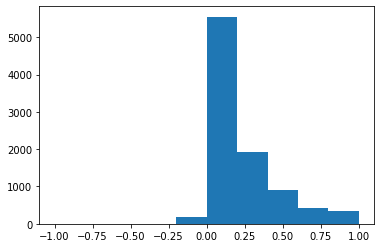

In [60]:
plt.hist(clinton_clinton_sims, range = (-1,1))
plt.show()

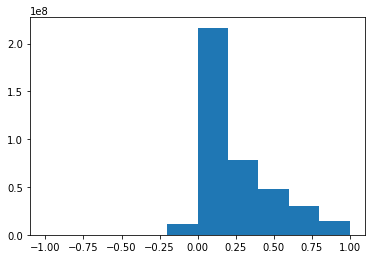

In [61]:
plt.hist(svd_cosine_sims.flatten(), range=(-1,1))
plt.show()

In [63]:
most_similar_50_users_svd = np.zeros((subreddit_tfidf.shape[0],50), dtype = np.int32)

for i in range(subreddit_tfidf.shape[0]):
    most_similar_50_users_svd[i] = np.flip(np.argsort(svd_cosine_sims[i])[-50:])


In [64]:
most_similar_50_users_svd[0]

array([  26,   14,    7,  531,   10,   35,  942,  882,    6,  102,  494,
          4,  111,   48,  353,  288,   64,    9,  131,   43,  105,   20,
        418,  839,   55,  571,  168,   88,   37,  383,  276,  425,   62,
         70, 1178,  644,   22,  240,  109,   93,   95,  143,  473,  307,
        504,   80,   44,   85,  609, 1055], dtype=int32)

In [65]:
most_similar_50_set = [set(i) for i in most_similar_50_users_svd]

In [81]:
print(np.mean([len(most_similar_50_set[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set[i].intersection(sanders_user_indices)) >= 10]))


14.33140655105973
6.0
103.33847141939627
203.71379310344827


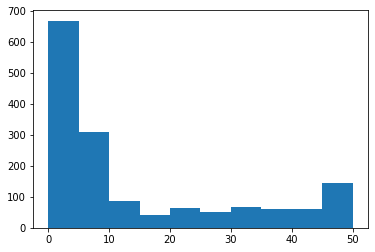

In [82]:
plt.hist([len(most_similar_50_set[i].intersection(sanders_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

In [83]:
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set[i].intersection(sanders_user_indices)) >= 10]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set[i].intersection(sanders_user_indices)) >= 30]))

580
335


7.269858541893362
3.0
140
77
97.14907508161045
253.77857142857144


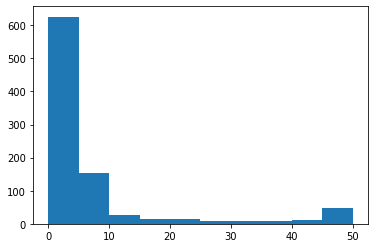

In [84]:
print(np.mean([len(most_similar_50_set[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set[i].intersection(trump_user_indices)) >= 10]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set[i].intersection(trump_user_indices)) >= 30]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set[i].intersection(trump_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

1.8759124087591241
1.0
2
0
95.81751824817518
152.5


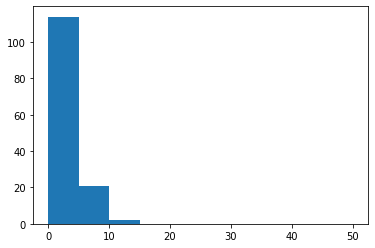

In [85]:
print(np.mean([len(most_similar_50_set[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set[i].intersection(clinton_user_indices)) >= 10]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set[i].intersection(clinton_user_indices)) >= 30]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set[i].intersection(clinton_user_indices)) >= 10]))


plt.hist([len(most_similar_50_set[i].intersection(clinton_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()

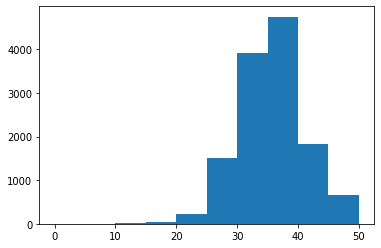

In [66]:
plt.hist([len(most_similar_50_set[i].intersection(none_user_indices)) for i in none_user_indices], range = (0,50))
plt.show()

## Try with Music and HipHopHeads

In [68]:
num_music = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['music']]) for k in author_names}
num_hhh = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['hiphopheads']]) for k in author_names}


In [69]:
music_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_music[author_names[i]] >= comment_threshold]
print(len(music_user_indices))
hhh_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_hhh[author_names[i]] >= comment_threshold]
print(len(hhh_user_indices))


2176
590


In [88]:
np.sum(svd_cosine_sims[music_user_indices, :][:,music_user_indices]) / \
(len(music_user_indices) * (len(music_user_indices)-1))

0.3541934109154698

In [89]:
np.sum(svd_cosine_sims[hhh_user_indices, :][:,hhh_user_indices]) / \
(len(hhh_user_indices) * (len(hhh_user_indices)-1))

0.25303707224553496

In [90]:
print(np.sum(svd_cosine_sims[music_user_indices, :][:,hhh_user_indices]) / \
((len(music_user_indices) * len(hhh_user_indices)) - \
len(set(music_user_indices).intersection(hhh_user_indices))))


0.2368393542015716


In [91]:
print(len(set(most_similar_user_svd[music_user_indices]).intersection(music_user_indices)))
print(len(set(most_similar_user_svd[music_user_indices]).intersection(music_user_indices))/len(music_user_indices))
print(len(set(most_similar_user_svd[music_user_indices]).intersection(hhh_user_indices)))
print(len(set(most_similar_user_svd[music_user_indices]).intersection(hhh_user_indices))/len(hhh_user_indices))

print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(hhh_user_indices)))
print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(hhh_user_indices))/len(hhh_user_indices))
print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(music_user_indices)))
print(len(set(most_similar_user_svd[hhh_user_indices]).intersection(music_user_indices))/len(music_user_indices))

356
0.1636029411764706
74
0.12542372881355932
143
0.2423728813559322
101
0.04641544117647059


In [70]:
music_music_sims = []

for i in range(len(music_user_indices)):
    for j in range(i+1, len(music_user_indices)):
        music_music_sims.append(svd_cosine_sims[music_user_indices[i],music_user_indices[j]])

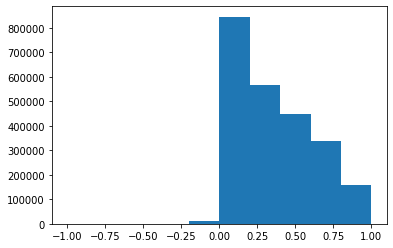

In [71]:
plt.hist(music_music_sims, range = (-1,1))
plt.show()

In [72]:
hhh_hhh_sims = []

for i in range(len(hhh_user_indices)):
    for j in range(i+1, len(hhh_user_indices)):
        hhh_hhh_sims.append(svd_cosine_sims[hhh_user_indices[i],hhh_user_indices[j]])

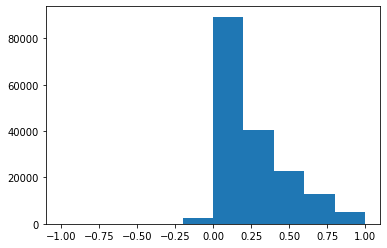

In [73]:
plt.hist(hhh_hhh_sims, range = (-1,1) )
plt.show()

8.943014705882353
8.0
899
0
37.385110294117645
39.22691879866518


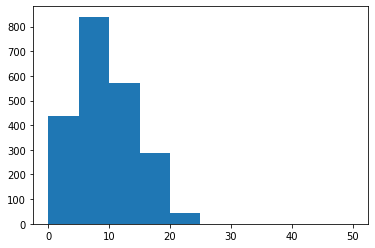

In [74]:
print(np.mean([len(most_similar_50_set[i].intersection(music_user_indices)) for i in music_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(music_user_indices)) for i in music_user_indices]))
print(sum([1 for i in music_user_indices if len(most_similar_50_set[i].intersection(music_user_indices)) >= 10]))
print(sum([1 for i in music_user_indices if len(most_similar_50_set[i].intersection(music_user_indices)) >= 30]))
print(np.mean([num_music[author_names[i]] for i in music_user_indices]))
print(np.mean([num_music[author_names[i]] for i in music_user_indices if len(most_similar_50_set[i].intersection(music_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set[i].intersection(music_user_indices)) for i in music_user_indices], range = (0,50))
plt.show()

12.686440677966102
4.0
179
119
128.61016949152543
287.92737430167597


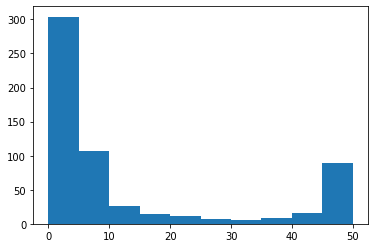

In [97]:
print(np.mean([len(most_similar_50_set[i].intersection(hhh_user_indices)) for i in hhh_user_indices]))
print(np.median([len(most_similar_50_set[i].intersection(hhh_user_indices)) for i in hhh_user_indices]))
print(sum([1 for i in hhh_user_indices if len(most_similar_50_set[i].intersection(hhh_user_indices)) >= 10]))
print(sum([1 for i in hhh_user_indices if len(most_similar_50_set[i].intersection(hhh_user_indices)) >= 30]))
print(np.mean([num_hhh[author_names[i]] for i in hhh_user_indices]))
print(np.mean([num_hhh[author_names[i]] for i in hhh_user_indices if len(most_similar_50_set[i].intersection(hhh_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set[i].intersection(hhh_user_indices)) for i in hhh_user_indices], range = (0,50))
plt.show()

## Check if similarities persist after removing SFP, TD, HC

In [15]:
subreddit_tfidf_modified = csc_matrix(subreddit_tfidf)
subreddit_tfidf_modified[:, subreddit_reverse_dict['sandersforpresident']] = 0
subreddit_tfidf_modified[:, subreddit_reverse_dict['the_donald']] = 0
subreddit_tfidf_modified[:, subreddit_reverse_dict['hillaryclinton']] = 0
subreddit_tfidf_modified = csr_matrix(subreddit_tfidf_modified)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [34]:
subreddit_tfidf_norms_m = np.zeros(subreddit_tfidf.shape[0])

In [35]:
for i in range(20):
    subreddit_tfidf_norms_m[i*1000 : (i+1) * 1000] = norm(subreddit_tfidf_modified[i*1000 : (i+1) * 1000].toarray(), axis=1)

In [36]:
subreddit_tfidf_normalized_m = csr_matrix(subreddit_tfidf_modified / subreddit_tfidf_norms_m[:, np.newaxis])

In [37]:
subreddit_cosine_sims_m = np.zeros((subreddit_tfidf_modified.shape[0], subreddit_tfidf_modified.shape[0]))

In [38]:
for i in range(20):
    chunk1 = subreddit_tfidf_normalized_m[i*1000 : (i+1)*1000, :]
    for j in range(20):
        chunk2 = subreddit_tfidf_normalized_m[j*1000 : (j+1)*1000, :]
        subreddit_cosine_sims_m[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(csc_matrix(chunk2.T)).toarray()


In [40]:
for i in range(subreddit_tfidf.shape[0]):
    subreddit_cosine_sims_m[i,i] = 0

In [41]:
most_similar_user_m = np.zeros(subreddit_tfidf.shape[0], dtype = np.int32)

In [42]:
for i in range(subreddit_tfidf.shape[0]):
    most_similar_user_m[i] = np.argsort(subreddit_cosine_sims_m[i])[-1]

In [43]:
np.sum(subreddit_cosine_sims_m[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.11560929970550966

In [44]:
np.sum(subreddit_cosine_sims_m[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.09239368856412604

In [45]:
np.sum(subreddit_cosine_sims_m[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.10987153896207406

In [46]:
np.sum(subreddit_cosine_sims_m[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.0982426762905685

In [47]:
np.sum(subreddit_cosine_sims_m) / (subreddit_cosine_sims_m.shape[0] * (subreddit_cosine_sims_m.shape[1] - 1))

0.09629370233897037

In [48]:
print(np.sum(subreddit_cosine_sims_m[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(subreddit_cosine_sims_m[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(subreddit_cosine_sims_m[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(subreddit_cosine_sims_m[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims_m[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims_m[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.10172995911582774
0.10047826092227526
0.08602552204315879

0.10223058415053418
0.09056644815137545
0.07901326157043914


In [49]:
print(len([i for i in most_similar_user_m[sanders_user_indices] if i in set(sanders_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[sanders_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user_m[sanders_user_indices] if i in set(trump_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[sanders_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user_m[sanders_user_indices] if i in set(clinton_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[sanders_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user_m[sanders_user_indices] if i in set(none_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[sanders_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(sanders_user_indices)))
print()
print(len([i for i in most_similar_user_m[trump_user_indices] if i in set(sanders_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[trump_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_m[trump_user_indices] if i in set(trump_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[trump_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_m[trump_user_indices] if i in set(clinton_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[trump_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_m[trump_user_indices] if i in set(none_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[trump_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(trump_user_indices)))
print()
print(len([i for i in most_similar_user_m[clinton_user_indices] if i in set(sanders_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[clinton_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user_m[clinton_user_indices] if i in set(trump_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[clinton_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user_m[clinton_user_indices] if i in set(clinton_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[clinton_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user_m[clinton_user_indices] if i in set(none_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[clinton_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(clinton_user_indices)))
print()
print(len([i for i in most_similar_user_m[none_user_indices] if i in set(sanders_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[none_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(none_user_indices)))
print(len([i for i in most_similar_user_m[none_user_indices] if i in set(trump_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[none_user_indices] if i in set(trump_user_indices)])/(len(none_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_m[none_user_indices] if i in set(clinton_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[none_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(none_user_indices)))
print(len([i for i in most_similar_user_m[none_user_indices] if i in set(none_user_indices)]))
print(subreddit_cosine_sims_m.shape[0] * len([i for i in most_similar_user_m[none_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(none_user_indices)))


154
1.270496553778098
91
1.2719418708587635
15
1.4064104186883817
935
0.926861874681732

74
1.034326356522511
95
2.2496894836489014
5
0.794262249509543
533
0.8951662867948194

14
1.3126497241091561
8
1.2708195992152689
9
9.590281847727637
83
0.9350816731878286

736
0.7295939462735345
533
0.8951662867948194
51
0.5745682570190273
8917
1.0621181029115139


## SVD without SFP, TD, HC

In [16]:
user_svd_m = TruncatedSVD(n_components = 100)
user_svd_points_m = user_svd_m.fit_transform(subreddit_tfidf_modified)

In [17]:
user_svd_norms_m = np.zeros(subreddit_tfidf.shape[0])

In [18]:
for i in range(20):
    user_svd_norms_m[i*1000 : (i+1) * 1000] = norm(user_svd_points_m[i*1000 : (i+1) * 1000], axis=1)

In [19]:
user_svd_norms_m[:10]

array([ 1753.83992315,   750.87548903,  5471.17854682, 21267.99506841,
        3371.44456924,  2547.71193782,  1416.95221379,  9777.51118565,
         798.13038163,  7842.35881961])

In [20]:
user_svd_normalized_m = user_svd_points_m / user_svd_norms_m[:, np.newaxis]

In [21]:
svd_cosine_sims_m = np.zeros((subreddit_tfidf.shape[0], subreddit_tfidf.shape[0]))

In [22]:
for i in range(20):
    chunk1 = csr_matrix(user_svd_normalized_m[i*1000 : (i+1)*1000, :])
    for j in range(i,20):
        chunk2 = csc_matrix(user_svd_normalized_m[j*1000 : (j+1)*1000, :].T)
        svd_cosine_sims_m[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(chunk2).toarray()


In [23]:
svd_cosine_sims_m[:10,:10]

array([[1.        , 0.69082423, 0.4009337 , 0.62434446, 0.77886594,
        0.59976948, 0.78557344, 0.83216111, 0.12281697, 0.77655676],
       [0.69082423, 1.        , 0.39647548, 0.81779103, 0.77692345,
        0.57892492, 0.81393508, 0.82698898, 0.10827571, 0.80789643],
       [0.4009337 , 0.39647548, 1.        , 0.72253875, 0.20035793,
        0.34506657, 0.33423419, 0.351985  , 0.04677952, 0.35112288],
       [0.62434446, 0.81779103, 0.72253875, 1.        , 0.5534058 ,
        0.46765779, 0.67906742, 0.70965938, 0.07294955, 0.67802127],
       [0.77886594, 0.77692345, 0.20035793, 0.5534058 , 1.        ,
        0.70253998, 0.8939203 , 0.92976546, 0.15200476, 0.79876593],
       [0.59976948, 0.57892492, 0.34506657, 0.46765779, 0.70253998,
        1.        , 0.63710394, 0.62807666, 0.16120355, 0.66243645],
       [0.78557344, 0.81393508, 0.33423419, 0.67906742, 0.8939203 ,
        0.63710394, 1.        , 0.92811069, 0.1127271 , 0.86141901],
       [0.83216111, 0.82698898, 0.351985 

In [24]:
for i in range(subreddit_tfidf.shape[0]):
    svd_cosine_sims_m[i,i] = 0

In [25]:
for i in range(20):
    for j in range(i):
        svd_cosine_sims_m[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = \
svd_cosine_sims_m[j*1000 : (j+1)*1000, i*1000 : (i+1)*1000].T

In [26]:
svd_cosine_sims_m[3872,10415]

0.5097630649293913

In [27]:
svd_cosine_sims_m[10415,3872]

0.5097630649293913

In [28]:
most_similar_user_svd_m = np.zeros(subreddit_tfidf.shape[0], dtype = np.int32)

In [29]:
for i in range(subreddit_tfidf.shape[0]):
    most_similar_user_svd_m[i] = np.argsort(svd_cosine_sims_m[i])[-1]

In [30]:
most_similar_user_svd_m[:10]

array([   26,    46,   828,   946,    16,  4214,    64,   942, 12012,
          43], dtype=int32)

In [31]:
[svd_cosine_sims_m[i, most_similar_user_svd_m[i]] for i in range(10)]

[0.9065289233298915,
 0.9272107483169616,
 0.9722755733267259,
 0.9851099431564582,
 0.9577826995768564,
 0.7671663020565638,
 0.9528547815939193,
 0.9616396738585347,
 0.9878481646850883,
 0.9370551370743466]

In [32]:
np.sum(svd_cosine_sims_m[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.2623451239328552

In [40]:
np.sum(svd_cosine_sims_m[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.21623163807739687

In [41]:
np.sum(svd_cosine_sims_m[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.22392113887854653

In [42]:
np.sum(svd_cosine_sims_m[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.2540551920083579

In [43]:
np.sum(svd_cosine_sims_m) / (svd_cosine_sims_m.shape[0] * (svd_cosine_sims_m.shape[1] - 1))

0.24675364407409253

In [44]:
print(np.sum(svd_cosine_sims_m[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(svd_cosine_sims_m[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(svd_cosine_sims_m[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(svd_cosine_sims_m[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims_m[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(svd_cosine_sims_m[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.23611804227863864
0.22082826112713277
0.19205718653634363

0.2493614891030537
0.2255019885807114
0.18887873578199213


In [33]:
print(len([i for i in most_similar_user_svd_m[sanders_user_indices] if i in set(sanders_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[sanders_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user_svd_m[sanders_user_indices] if i in set(trump_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[sanders_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user_svd_m[sanders_user_indices] if i in set(clinton_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[sanders_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(sanders_user_indices)))
print(len([i for i in most_similar_user_svd_m[sanders_user_indices] if i in set(none_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[sanders_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(sanders_user_indices)))
print()
print(len([i for i in most_similar_user_svd_m[trump_user_indices] if i in set(sanders_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[trump_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_svd_m[trump_user_indices] if i in set(trump_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[trump_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_svd_m[trump_user_indices] if i in set(clinton_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[trump_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_svd_m[trump_user_indices] if i in set(none_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[trump_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(trump_user_indices)))
print()
print(len([i for i in most_similar_user_svd_m[clinton_user_indices] if i in set(sanders_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[clinton_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user_svd_m[clinton_user_indices] if i in set(trump_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[clinton_user_indices] if i in set(trump_user_indices)])/(len(trump_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user_svd_m[clinton_user_indices] if i in set(clinton_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[clinton_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(clinton_user_indices)))
print(len([i for i in most_similar_user_svd_m[clinton_user_indices] if i in set(none_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[clinton_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(clinton_user_indices)))
print()
print(len([i for i in most_similar_user_svd_m[none_user_indices] if i in set(sanders_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[none_user_indices] if i in set(sanders_user_indices)])/(len(sanders_user_indices)*len(none_user_indices)))
print(len([i for i in most_similar_user_svd_m[none_user_indices] if i in set(trump_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[none_user_indices] if i in set(trump_user_indices)])/(len(none_user_indices)*len(trump_user_indices)))
print(len([i for i in most_similar_user_svd_m[none_user_indices] if i in set(clinton_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[none_user_indices] if i in set(clinton_user_indices)])/(len(clinton_user_indices)*len(none_user_indices)))
print(len([i for i in most_similar_user_svd_m[none_user_indices] if i in set(none_user_indices)]))
print(svd_cosine_sims_m.shape[0] * len([i for i in most_similar_user_svd_m[none_user_indices] if i in set(none_user_indices)])/(len(none_user_indices)*len(none_user_indices)))


187
1.542745815301976
114
1.5934216843725169
28
2.6252994482183123
912
0.904062063860684

88
1.230009721270013
62
1.4682183998550726
7
1.1119671493133603
547
0.9186790973297677

14
1.3126497241091561
11
1.7473769489209947
6
6.393521231818424
80
0.9012835404220035

893
0.8852274375302531
539
0.9052432055955115
73
0.8224212306350782
8759
1.0432984707190702


In [46]:
sanders_sanders_sims_m = []

for i in range(len(sanders_user_indices)):
    for j in range(i+1, len(sanders_user_indices)):
        sanders_sanders_sims_m.append(svd_cosine_sims_m[i,j])

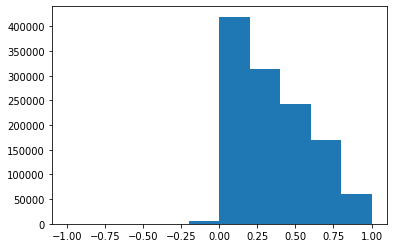

In [47]:
plt.hist(sanders_sanders_sims_m, range = (-1,1))
plt.show()

In [48]:
trump_trump_sims_m = []

for i in range(len(trump_user_indices)):
    for j in range(i+1, len(trump_user_indices)):
        trump_trump_sims_m.append(svd_cosine_sims_m[i,j])

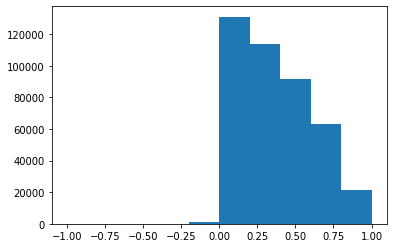

In [49]:
plt.hist(trump_trump_sims_m, range = (-1,1) )
plt.show()

In [50]:
clinton_clinton_sims_m = []

for i in range(len(clinton_user_indices)):
    for j in range(i+1, len(clinton_user_indices)):
        clinton_clinton_sims_m.append(svd_cosine_sims_m[i,j])

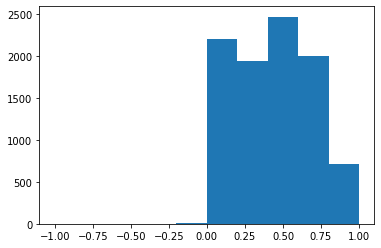

In [51]:
plt.hist(clinton_clinton_sims_m, range = (-1,1))
plt.show()

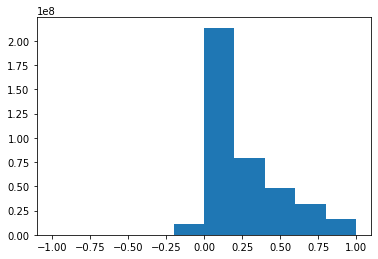

In [53]:
plt.hist(svd_cosine_sims_m.flatten(), range=(-1,1))
plt.show()

In [54]:
most_similar_50_users_svd_m = np.zeros((subreddit_tfidf.shape[0],50), dtype = np.int32)

for i in range(subreddit_tfidf.shape[0]):
    most_similar_50_users_svd_m[i] = np.flip(np.argsort(svd_cosine_sims_m[i])[-50:])


In [55]:
most_similar_50_users_svd_m[0]

array([  26,   14,    7,  531,   10,  942,  882,    6,   35,  102,  494,
          4,  111,  353,   48,   16,   43,  418,  109,    9,   20,   64,
        288,  131,  105,   55,   37,  571,   88,  839,  276,  644,   62,
        425,  168,   22, 1178,  307,   44,  504,  240,  473,   80,   93,
         95, 1055, 1532,   85,  383,   70], dtype=int32)

In [56]:
most_similar_50_set_m = [set(i) for i in most_similar_50_users_svd_m]

In [57]:
print(np.mean([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))


5.619139370584457
4.0
103.33847141939627
129.4787234042553
173.056


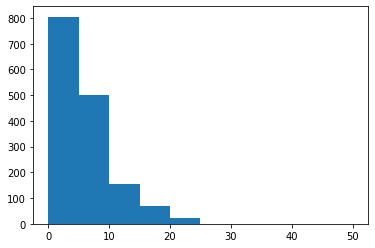

In [58]:
plt.hist([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

In [65]:
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 30]))

752
250
0


3.189336235038085
3.0
215
18
0
97.14907508161045
109.76744186046511
49.111111111111114


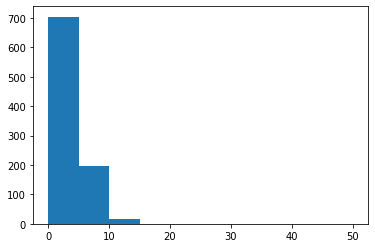

In [60]:
print(np.mean([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 30]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

1.489051094890511
1.0
20
0
0


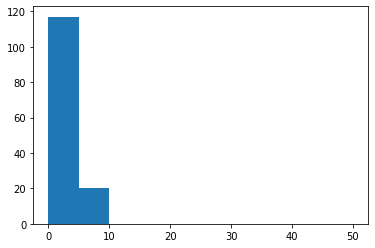

In [61]:
print(np.mean([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 30]))
# print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
# print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))


plt.hist([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()

### Similarities across groups

### Sanders

5.619139370584457
4.0
752
250
103.33847141939627
129.4787234042553
173.056


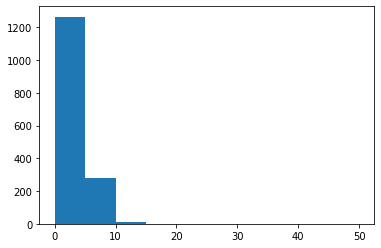

In [74]:
print(np.mean([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in sanders_user_indices]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

2.823378291586384
3.0
292
12
14.23956326268465
17.65753424657534
11.416666666666666
103.33847141939627
133.93835616438355
63.833333333333336


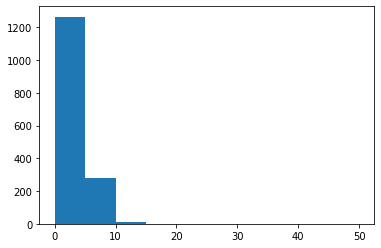

In [75]:
print(np.mean([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in sanders_user_indices]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_trump[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

0.6210661528580603
0.0
49
0
5.449582530507386
57.87755102040816
103.33847141939627
112.77551020408163


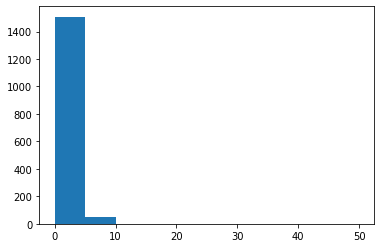

In [79]:
print(np.mean([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in sanders_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in sanders_user_indices]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
print(sum([1 for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_clinton[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in sanders_user_indices], range = (0,50))
plt.show()

### Trump

3.189336235038085
3.0
215
18
97.14907508161045
109.76744186046511
49.111111111111114


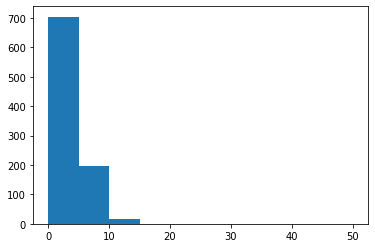

In [77]:
print(np.mean([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

4.936887921653971
4.0
397
101
0
97.14907508161045
111.55667506297229
139.05940594059405
18.98150163220892
30.869017632241814
51.15841584158416


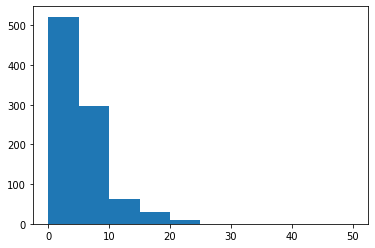

In [78]:
print(np.mean([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 30]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

0.528835690968444
0.0
21
0
1.0848748639825898
1.619047619047619
97.14907508161045
208.23809523809524


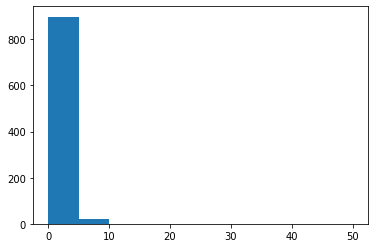

In [81]:
print(np.mean([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in trump_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in trump_user_indices]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
print(sum([1 for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_clinton[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in trump_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_sanders[author_names[i]] for i in sanders_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in trump_user_indices], range = (0,50))
plt.show()

### Clinton

1.489051094890511
1.0
20
0
95.81751824817518
210.65


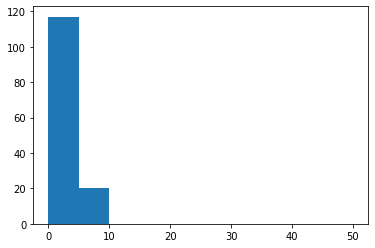

In [83]:
print(np.mean([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 5]))
# print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(clinton_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(clinton_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()

7.08029197080292
5.0
77
39
95.81751824817518
127.98701298701299
143.28205128205127
125.0
176.7922077922078
89.71794871794872


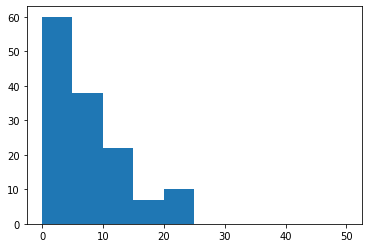

In [85]:
print(np.mean([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))
print(np.mean([num_sanders[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_sanders[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 5]))
print(np.mean([num_sanders[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(sanders_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(sanders_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()

3.065693430656934
3.0
29
2
12.81021897810219
3.0344827586206895
12.5
95.81751824817518
69.06896551724138
102.5


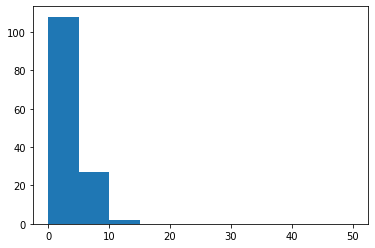

In [86]:
print(np.mean([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in clinton_user_indices]))
print(np.median([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in clinton_user_indices]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(sum([1 for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_trump[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_trump[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_trump[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 5]))
print(np.mean([num_clinton[author_names[i]] for i in clinton_user_indices if len(most_similar_50_set_m[i].intersection(trump_user_indices)) >= 10]))

plt.hist([len(most_similar_50_set_m[i].intersection(trump_user_indices)) for i in clinton_user_indices], range = (0,50))
plt.show()